In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import RMSprop
import tensorflow as tf
from ipynb.fs.full.plotter_class import Plotter
from ipynb.fs.full.time_series_data import TimeSeriesData
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from ipynb.fs.full.dataset_creator import SupervisedDatasetCreator
from ipynb.fs.full.dataset_scaler import DatasetScaler
from ipynb.fs.full.dataset_scaler_manager import DataScalerManager
from ipynb.fs.full.lstm import LSTMModel

In [14]:
INPUT_LENGTH = 24   
OUTPUT_LENGTH = 1
EPOCHS = 20
BATCH_SIZE = 256
LEARNING_RATE = 5.5e-4
N_UNITS = 256 #128 

In [15]:
data_path = './../data'
file_name = 'weather_dataset_preprocesado.csv'
ts_data = TimeSeriesData(data_path, file_name)
series = ts_data.df['T (degC)']

In [ ]:
train, val, test = ts_data.train_val_test_split(series)

print(f'Tamaño set de entrenamiento: {train.shape}')
print(f'Tamaño set de validación: {val.shape}')
print(f'Tamaño set de prueba: {test.shape}')

In [ ]:
plotter = Plotter()

plotter.plot(train, label='Train')
plotter.plot(val, label='Val')
plotter.plot(test, label='Test')
plotter.configure(title='Weather plot (Train, val, and test)', ylabel='Temperature (°C)')
plotter.show()

In [18]:
preprocessor = SupervisedDatasetCreator(INPUT_LENGTH, OUTPUT_LENGTH)
x_train, y_train = preprocessor.create_supervised_dataset(train.values)
x_val, y_val = preprocessor.create_supervised_dataset(val.values)
x_test, y_test = preprocessor.create_supervised_dataset(test.values)

In [ ]:
print('Tamaños entrada (BATCHES x INPUT_LENGTH x FEATURES) y de salida (BATCHES x OUTPUT_LENGTH x FEATURES)')
print(f'Set de entrenamiento    \t x_train: {x_train.shape}, y_train: {y_train.shape}')
print(f'Set de validación       \t x_val: {x_val.shape}, y_val: {y_val.shape}')
print(f'Set de prueba           \t x_test: {x_test.shape}, y_test: {y_test.shape}')

In [20]:
data_in = {
    'x_train': x_train, 'y_train': y_train,
    'x_val': x_val, 'y_val': y_val,
    'x_test': x_test, 'y_test': y_test,
}

data_scaler_manager = DataScalerManager()
scaled_data, scaler = data_scaler_manager.scale_data(data_in)

In [21]:
x_train_s, y_train_s = scaled_data['x_train'], scaled_data['y_train']
x_val_s, y_val_s = scaled_data['x_val'], scaled_data['y_val']
x_test_s, y_test_s = scaled_data['x_test'], scaled_data['y_test']

In [22]:
input_shape = (x_train_s.shape[1], x_train_s.shape[2])  

In [ ]:
lstm_model = LSTMModel(n_units=N_UNITS, input_shape=input_shape, learning_rate=LEARNING_RATE)
model = lstm_model.model

In [ ]:
early_stopping = EarlyStopping(patience=6, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(factor=0.5, patience=3, min_lr=1e-7)

history = model.fit(
    x_train_s, y_train_s, epochs=EPOCHS, batch_size=BATCH_SIZE,
    validation_data=(x_val_s, y_val_s), verbose=2,
    callbacks=[early_stopping, reduce_lr]
)

In [ ]:
plt.plot(history.history['loss'], label='RMSE Train')
plt.plot(history.history['val_loss'], label='RMSE Val')
plt.xlabel('Epochs')
plt.ylabel('RMSE')

plotter.configure(title='Epochs vs RMSE', xlabel='Epochs', ylabel='RMSE')
plotter.show()

In [ ]:
rmse_tr = model.evaluate(x=x_train_s, y=y_train_s, verbose=0)
rmse_vl = model.evaluate(x=x_val_s, y=y_val_s, verbose=0)
rmse_ts = model.evaluate(x=x_test_s, y=y_test_s, verbose=0)

print('Comparativo desempeños:')
print(f'  RMSE train:\t {rmse_tr:.3f}')
print(f'  RMSE val:\t {rmse_vl:.3f}')
print(f'  RMSE test:\t {rmse_ts:.3f}')

In [16]:
def predecir(x, model, scaler):
    '''Genera la predicción de OUTPUT_LENGTH instantes
    de tiempo a futuro con el modelo entrenado.

    Entrada:
    - x: batch (o batches) de datos para ingresar al modelo
      (tamaño: BATCHES X INPUT_LENGTH X FEATURES)
    - model: Red LSTM entrenada
    - scaler: escalador (requerido para llevar la predicción a la escala original)
    
    Salida:
    - y_pred: la predicción en la escala original (tamaño: BATCHES X OUTPUT_LENGTH X FEATURES)
    '''

    y_pred_s = model.predict(x,verbose=0)
    y_pred = scaler.inverse_transform(y_pred_s)

    return y_pred.flatten()

In [17]:
y_test_pred = predecir(x_test_s, model, scaler)

In [ ]:
N = len(y_test_pred)   
ndato = np.linspace(1,N,N)

errores = y_test.flatten()-y_test_pred
plt.plot(errores);

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import tensorflow as tf
from ipynb.fs.full.plotter_class import Plotter
from ipynb.fs.full.time_series_data import TimeSeriesData
from ipynb.fs.full.dataset_creator import SupervisedDatasetCreator
from ipynb.fs.full.dataset_scaler import DatasetScaler
from ipynb.fs.full.dataset_scaler_manager import DataScalerManager
from ipynb.fs.full.lstm import LSTMModel


class WeatherPredictionPipeline:
    def __init__(self, data_path, file_name, input_length=24, output_length=1, epochs=20, batch_size=128, 
                 learning_rate=5.5e-4, n_units=256):
        self.data_path = data_path
        self.file_name = file_name
        self.input_length = input_length
        self.output_length = output_length
        self.epochs = epochs
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.n_units = n_units

        # Initialize components
        self.ts_data = TimeSeriesData(data_path, file_name)
        self.plotter = Plotter()
        self.preprocessor = SupervisedDatasetCreator(input_length, output_length)
        self.data_scaler_manager = DataScalerManager()

    def load_and_split_data(self):
        series = self.ts_data.df['T (degC)']
        train, val, test = self.ts_data.train_val_test_split(series)
        self._plot_data(train, val, test)
        return train, val, test

    def _plot_data(self, train, val, test):
        """Plot training, validation, and test datasets."""
        self.plotter.plot(train, label='Train')
        self.plotter.plot(val, label='Val')
        self.plotter.plot(test, label='Test')
        self.plotter.configure(title='Weather plot (Train, val, and test)', ylabel='Temperature (°C)')
        self.plotter.show()

    def preprocess_data(self, train, val, test):
        x_train, y_train = self.preprocessor.create_supervised_dataset(train.values)
        x_val, y_val = self.preprocessor.create_supervised_dataset(val.values)
        x_test, y_test = self.preprocessor.create_supervised_dataset(test.values)

        print('Data Shapes:')
        print(f'  Training set - x_train: {x_train.shape}, y_train: {y_train.shape}')
        print(f'  Validation set - x_val: {x_val.shape}, y_val: {y_val.shape}')
        print(f'  Test set - x_test: {x_test.shape}, y_test: {y_test.shape}')

        return {'x_train': x_train, 'y_train': y_train,
                'x_val': x_val, 'y_val': y_val,
                'x_test': x_test, 'y_test': y_test}

    def scale_data(self, data_in):
        scaled_data, scaler = self.data_scaler_manager.scale_data(data_in)
        return scaled_data, scaler

    def build_and_train_model(self, x_train_s, y_train_s, x_val_s, y_val_s):
        input_shape = (x_train_s.shape[1], x_train_s.shape[2])
        lstm_model = LSTMModel(n_units=self.n_units, input_shape=input_shape, learning_rate=self.learning_rate)
        model = lstm_model.model

        early_stopping = EarlyStopping(patience=6, restore_best_weights=True)
        reduce_lr = ReduceLROnPlateau(factor=0.5, patience=3, min_lr=1e-7)

        history = model.fit(
            x_train_s, y_train_s, epochs=self.epochs, batch_size=self.batch_size,
            validation_data=(x_val_s, y_val_s), verbose=2,
            callbacks=[early_stopping, reduce_lr]
        )
        self._plot_training_history(history)
        return model

    def _plot_training_history(self, history):
        """Plot training and validation loss over epochs."""
        plt.plot(history.history['loss'], label='RMSE Train')
        plt.plot(history.history['val_loss'], label='RMSE Val')
        plt.xlabel('Epochs')
        plt.ylabel('RMSE')
        self.plotter.configure(title='Epochs vs RMSE', xlabel='Epochs', ylabel='RMSE')
        self.plotter.show()

    def evaluate_model(self, model, x_train_s, y_train_s, x_val_s, y_val_s, x_test_s, y_test_s):
        rmse_tr = model.evaluate(x=x_train_s, y=y_train_s, verbose=0)
        rmse_vl = model.evaluate(x=x_val_s, y=y_val_s, verbose=0)
        rmse_ts = model.evaluate(x=x_test_s, y=y_test_s, verbose=0)

        print('Performance Comparison:')
        print(f'  RMSE Train: {rmse_tr:.3f}')
        print(f'  RMSE Val: {rmse_vl:.3f}')
        print(f'  RMSE Test: {rmse_ts:.3f}')

    def predict(self, x, model, scaler):
        """Generate predictions with the trained model."""
        y_pred_s = model.predict(x, verbose=0)
        y_pred = scaler.inverse_transform(y_pred_s)
        return y_pred.flatten()

    def plot_errors(self, y_true, y_pred):
        """Plot prediction errors."""
        errors = y_true.flatten() - y_pred
        plt.plot(errors)
        plt.title("Prediction Errors")
        plt.show()

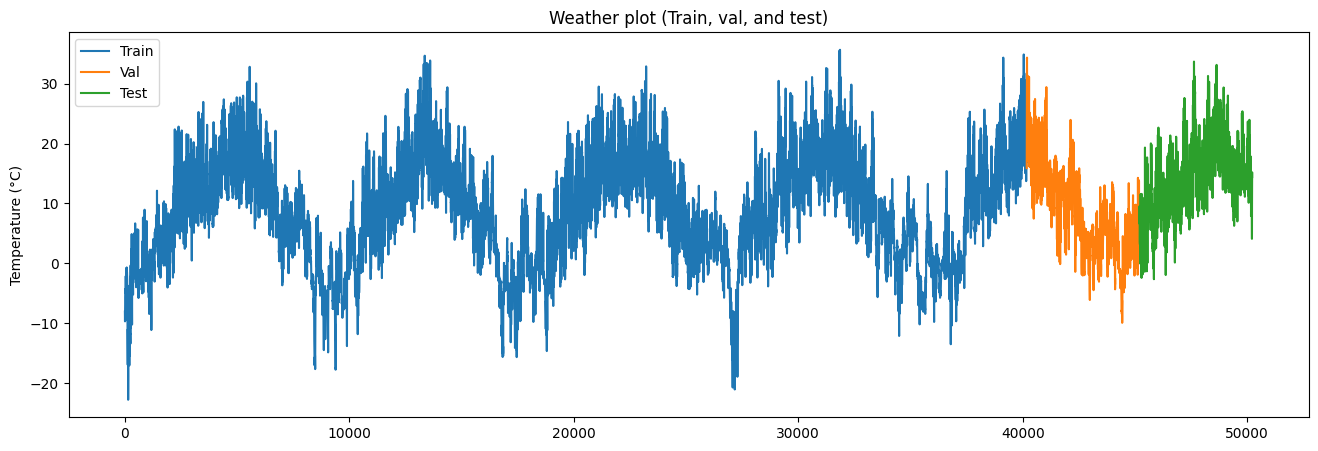

Data Shapes:
  Training set - x_train: (40154, 24, 1), y_train: (40154, 1, 1)
  Validation set - x_val: (4997, 24, 1), y_val: (4997, 1, 1)
  Test set - x_test: (4998, 24, 1), y_test: (4998, 1, 1)


c:\Sevann\UBA\LSMT-weather\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
157/157 - 53s - 337ms/step - loss: 0.0733 - val_loss: 0.0412 - learning_rate: 5.5000e-04
Epoch 2/20
157/157 - 51s - 324ms/step - loss: 0.0412 - val_loss: 0.0294 - learning_rate: 5.5000e-04
Epoch 3/20
157/157 - 51s - 327ms/step - loss: 0.0339 - val_loss: 0.0249 - learning_rate: 5.5000e-04
Epoch 4/20
157/157 - 50s - 318ms/step - loss: 0.0312 - val_loss: 0.0248 - learning_rate: 5.5000e-04
Epoch 5/20
157/157 - 46s - 292ms/step - loss: 0.0307 - val_loss: 0.0242 - learning_rate: 5.5000e-04
Epoch 6/20
157/157 - 39s - 249ms/step - loss: 0.0299 - val_loss: 0.0240 - learning_rate: 5.5000e-04
Epoch 7/20
157/157 - 37s - 237ms/step - loss: 0.0298 - val_loss: 0.0237 - learning_rate: 5.5000e-04
Epoch 8/20
157/157 - 38s - 240ms/step - loss: 0.0292 - val_loss: 0.0250 - learning_rate: 5.5000e-04
Epoch 9/20
157/157 - 40s - 252ms/step - loss: 0.0295 - val_loss: 0.0236 - learning_rate: 5.5000e-04
Epoch 10/20
157/157 - 36s - 229ms/step - loss: 0.0292 - val_loss: 0.0233 - learning_rate: 5.5000e-04

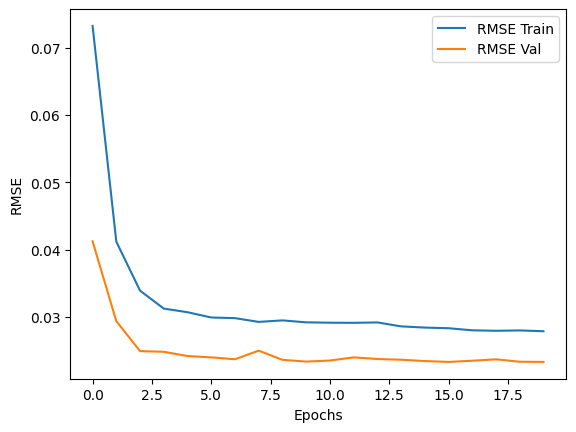

Performance Comparison:
  RMSE Train: 0.024
  RMSE Val: 0.022
  RMSE Test: 0.027


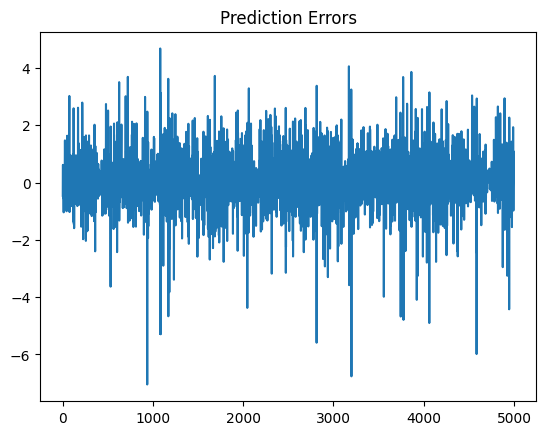

In [2]:
if __name__ == "__main__":
    pipeline = WeatherPredictionPipeline(
        data_path='./../data',
        file_name='weather_dataset_preprocesado.csv',
        input_length=24,
        output_length=1,
        epochs=20,
        batch_size=256,
        learning_rate=5.5e-4,
        n_units=256
    )

    # Load and preprocess data
    train, val, test = pipeline.load_and_split_data()
    data_in = pipeline.preprocess_data(train, val, test)
    scaled_data, scaler = pipeline.scale_data(data_in)

    # Train model
    model = pipeline.build_and_train_model(
        scaled_data['x_train'], scaled_data['y_train'],
        scaled_data['x_val'], scaled_data['y_val']
    )

    # Evaluate model
    pipeline.evaluate_model(
        model, scaled_data['x_train'], scaled_data['y_train'],
        scaled_data['x_val'], scaled_data['y_val'],
        scaled_data['x_test'], scaled_data['y_test']
    )

    # Predict and plot errors
    y_test_pred = pipeline.predict(scaled_data['x_test'], model, scaler)
    pipeline.plot_errors(data_in['y_test'], y_test_pred)